# Stock Clustering

In this notebook, we'll try to cluster the defined universe of stocks based on a combination of their historical financial ratios and their business descriptions gathered from prominent financial data sources.

1. We'll fetch historical financial ratios for all stocks from fiscal year 2010 to fiscal year 2022 - clean & preprocess data (data imputation), feature extraction from historical ratios data (dimensionality reduction) & finally data transformation

2. We'll fetch business descriptions (textual data) for all stocks from AlphaVantage - clean & preprocess data (remove stopwords, stemming/lemmatisation), text vectorisation (TFIDF -> LSA), feature engineering and data transformation 

3. Merge all features extracted from both the pre-processing methods and create a single uncorrelated feature space for model fitting

4. We'll explore various clustering models and fit these models on the preprocessed and transformed dataset - model fitting, hyper-parameter tuning

5. We'll evaluate the performance of all the models in consideration - intrinsic evaluation measures

6. Pick the best model to fit the data - fit it on the data and retrieve cluster labels for all observations (stocks)

---

In [143]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="white", rc={"figure.figsize":(8, 4)})
plt.style.use('ggplot') # fivethirtyeight, ggplot, dark_background, classic,  

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn import feature_extraction
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from scipy.spatial.distance import pdist, cdist

from kneed import KneeLocator
import re
import nltk
# nltk.download('stopwords') # required to be downloaded only for the first time
# nltk.download('wordnet') # required to be downloaded only for the first time
# nltk.download('omw-1.4') # required to be downloaded only for the first time
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

---

### Generic Util functions

These are generic util functions which could be reused for any of the tasks across sections

In [144]:
def std_normalise_data(data = pd.DataFrame()):
    """
    Standard scaling and Normalisation of input data

    Parameters:
    -----------
    data : pd.DataFrame
            raw data

    Returns: 
    --------
    new_df : pd.DataFrame
            scaled data
    """
    new_data = StandardScaler().fit_transform(data)
    new_data = Normalizer().fit_transform(new_data) 
    new_df = pd.DataFrame(new_data, index=data.index, columns=data.columns)
    return new_df

def knn_imputer(data: pd.DataFrame, n_neighbours: int=30):
    """
    Data imputation with KNNImputer

    Parameters:
    -----------
    data : pd.DataFrame
            raw data that needs to be imputed to handle missing values.

    n_neighbours : int, default value is 30
            Number of neighboring samples to use for imputation.

    Returns: 
    --------
    new_df : pd.DataFrame
            imputed data with zero NaN values.
    """
    # scale the data using minmaxscaler
    scaled_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(data)
    # Define KNN imputer and fill missing values
    knn_fit_data = KNNImputer(n_neighbors=n_neighbours, weights='distance').fit_transform(scaled_data)
    new_df = pd.DataFrame(knn_fit_data, columns=data.columns, index=data.index)

    # check if there are any more missing values after imputation
    print(f'Total count of missing values before imputing with KNNImputer: {data.isna().sum().sum()}')
    print(f'Total count of missing values after imputing with KNNImputer: {new_df.isna().sum().sum()}')
    return new_df

def pca_tuning(data = pd.DataFrame()):
    """
    PCA tuning - dimensionality reduction

    method 1 - Plot the cummulative explained variance against the count of principal components
    
    method 2 - Create a 'Scree' plot which gives the visual representation of eigenvalues 
    that define the magnitude of eigenvectors (principal components)

    Parameters:
    -----------
    data : pd.DataFrame
            data on which to fit the PCA model

    Returns: 
    --------
    pca_base : PCA object
            Fitted PCA model object

    knee_value : int
            computed Knee point from the Scree plot        
    """
    # Start with basic PCA, keeping all components with no reduction   
    pca_base = PCA()
    pca_base.fit(data)

    plt.figure(figsize=(12, 6))
    # Method 1
    # Fetch variance explained by each individual component & compute the cummulative sum
    print('Method 1 - variance explained by components') 
    plt.subplot(1, 2, 1)
    exp_var = pca_base.explained_variance_ratio_ * 100
    cum_exp_var = np.cumsum(exp_var)
    plt.bar(range(0, exp_var.size), exp_var, align='center', label='Individual explained variance (%)')
    plt.step(range(0, cum_exp_var.size), cum_exp_var, where='mid', label='Cumulative explained variance (%)', color='indigo')
    plt.ylabel('Explained variance (%)')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')

    # Method 2 - Scree plot
    print('\nMethod 2 - Scree plot')
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(pca_base.n_components_) + 1, pca_base.explained_variance_, 'ro-', linewidth=2,  color='orange')
    knee = KneeLocator(np.arange(pca_base.n_components_) + 1, pca_base.explained_variance_, S=20, 
                       curve='convex', direction='decreasing', interp_method='interp1d')
    plt.axvline(x=knee.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
    plt.figtext(0.65, 0.4, f'optimal n_comp = {knee.knee}', bbox=dict(facecolor='violet', alpha=0.3), fontsize=10)
    plt.title("Scree Plot")
    plt.xlabel("Principal component index")
    plt.ylabel("Eigenvalues")
    print(f'Knee point, eigenvalue : {knee.knee, pca_base.explained_variance_[knee.knee]}')
    plt.show()

    return pca_base, knee.knee

---

### 1. Historical Financial Ratios dataset

In [145]:
stock_ratios_df = pd.read_csv('../data/stocks_hist_ratios.csv')
print(f'Total count of stocks in hist ratios data: {len(stock_ratios_df.ticker.unique())}') 
stock_ratios_df.head()

Total count of stocks in hist ratios data: 502


ticker  Fiscal Date Ending Current ratio Quick ratio  Cash ratio Days of sales outstanding Days of inventory outstanding Operating cycle Days of payables outstanding Cash conversion cycle  Gross profit margin  Operating profit margin  Pretax profit margin  Net profit margin  Effective tax rate Return on assets Return on equity  Return on capital employed  Net income per EBT  Ebt per ebit  Ebit per revenue Debt ratio Debt equity ratio  Long term debt to capitalization  Total debt to capitalization Cash flow to debt ratio Company equity multiplier  Receivables turnover Payables turnover  Inventory turnover Fixed asset turnover Asset turnover  Operating cash flow per share  Free cash flow per share Cash per share  Payout ratio  Operating cash flow sales ratio  Free cash flow operating cash flow ratio Cash flow coverage ratios Short term coverage ratios Capital expenditure coverage ratio Dividend paid and capex coverage ratio  Dividend payout ratio Price book value ratio   
0    MMM                2010         2.006       1.344       0.555                    50.748                        83.260         134.009                       43.860                90.149                0.481                    0.222                 0.216              0.153               0.277            0.135            0.261                       0.246               0.710         0.972             0.222      0.469             0.903                             0.211                         0.258                   0.949                     1.925                 7.192             8.322               4.384                3.663          0.884                          7.250                     5.721          6.274         0.367                            0.194                                     0.789                     0.949                      4.077                             -4.742                                 12.650                  0.367                  3.984  \
1    MMM                2011         2.250       1.407       0.408                    49.010                        79.452         128.462                       38.214                90.248                0.470                    0.209                 0.204              0.145               0.278            0.135            0.278                       0.236               0.710         0.976             0.209      0.498             1.022                             0.225                         0.251                   1.023                     2.050                 7.447             9.551               4.594                3.863          0.937                          7.458                     5.512          5.194         0.363                            0.178                                     0.739                     1.023                      7.748                             -3.832                                 30.023                  0.363                  4.013   
2    MMM                2012         2.198       1.406       0.465                    51.093                        89.289         140.383                       53.011                87.372                0.475                    0.217                 0.212              0.149               0.290            0.131            0.253                       0.234               0.700         0.980             0.217      0.467             0.901                             0.219                         0.255                   0.883                     1.928                 7.144             6.885               4.088                3.569          0.883                          7.638                     5.499           6.53         0.368                            0.177                                     0.720                     0.883                      4.885                             -3.571                                 35.099                  0.368                  3.980   
3    MMM                2013         1.698       1.025

--------------------------------------------------
Data Imputation

Total count of missing values before imputing with KNNImputer: 6705
Total count of missing values after imputing with KNNImputer: 0
--------------------------------------------------
PCA for Dimensionality Reduction

Method 1 - variance explained by components

Method 2 - Scree plot
Knee point, eigenvalue : (12, 0.063552245)


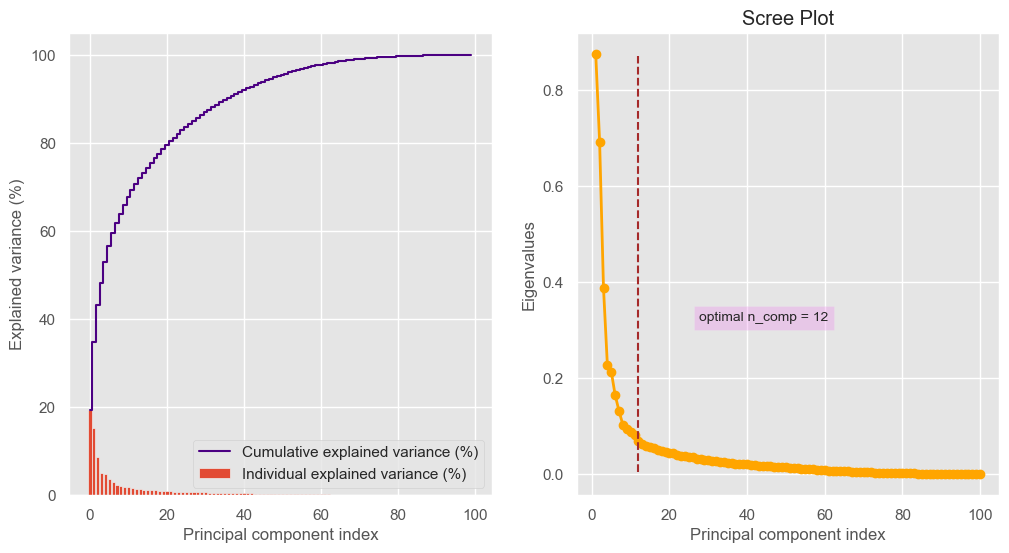

--------------------------------------------------
Fit a new PCA with n_components = 12 as observed from the Scree plot


In [146]:
def clean_preprocess_ratios_data(raw_data: pd.DataFrame, target_date_range: range=range(2010, 2020), copy: bool=True,
                                 target_ratios: list=['Quick ratio', 'Cash ratio', 'Interest coverage', 'Debt equity ratio', 'Asset turnover', 
                                                      'Receivables turnover', 'Return on assets', 'Operating profit margin', 
                                                      'Enterprise value multiple', 'Payout ratio']):
    """
    Perform data cleaning and preprocessing
    on raw historical financial ratios dataset.

    Parameters:
    -----------
    raw_data : pd.DataFrame
        large single dataframe of historical ratios for all the stocks.

    target_date_range : range
        range of fiscal years to be considered for fetching annual historical ratios measures.
        It's a range of years which includes the first value but not the last value. 

    copy : bool, default value is True
        If set to True, all processing will be done on a copy of the input raw data. 
        Else, the input raw data will be modified.
    
    target_ratios : list, default list of desired targets defined
        The list of specific ratios to be considered as the target feature set for model fitting. 

    Returns: 
    --------
    ratios_final_df : pd.DataFrame
        cleaned and processed dataframe of target historical ratio measures within the specified date range.
    """
    
    if copy:
        raw_data = raw_data.copy()
        
    # reshuffling DF into a pivot DF
    pivot_df = raw_data[['ticker', 'Fiscal Date Ending'] + target_ratios].pivot(
        index='ticker', columns='Fiscal Date Ending', values=target_ratios)

    # change the dtypes from object to float
    pivot_df = pivot_df.apply(pd.to_numeric, errors='coerce', downcast='float')

    # filter data only within the target date range
    target_df = pivot_df[[col_tup for col_tup in pivot_df.columns if col_tup[1] in target_date_range]]

    # data imputation of missing values
    # From our EDA, we found KNNImputer works the best on this data for n_neighbours=30
    print('-'*50)
    print('Data Imputation\n')
    target_imp_df = knn_imputer(target_df, n_neighbours=30)

    # PCA - dimensionality reduction
    # standard scaling and normalisation before fitting PCA
    print('-'*50)
    print('PCA for Dimensionality Reduction\n')
    scaled_df = std_normalise_data(target_imp_df)
    # Tune a default PCA model and find optimal n_components for fitting a PCA
    # Note: PCA needs the input data to be in (n_features, n_samples) format
    # for it to function properly and reduce the feature dimensionality
    pca_base, knee_value = pca_tuning(scaled_df.T)
    print('-'*50)
    print(f'Fit a new PCA with n_components = {knee_value} as observed from the Scree plot')
    # Fit a new PCA model with the obtained hyperparam value testing
    pca_final = PCA(n_components=knee_value)
    pca_final.fit(scaled_df.T) # Note: we need to input data in the exact required format here for the PCA to work properly

    # Structure the final results in a dataframe
    ratios_final_df = pd.DataFrame(pca_final.components_.T, index=scaled_df.index, columns=[f'PC_{i}' for i in 
                                                                                            range(pca_final.components_.T.shape[1])])
    
    return ratios_final_df

# clean and preprocess the stock ratios data
ratios_pp_df = clean_preprocess_ratios_data(stock_ratios_df)

In [147]:
ratios_pp_df.head()

PC_0      PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7      PC_8      PC_9     PC_10     PC_11
ticker                                                                                                                        
A      -0.022969  0.019944  0.084420  0.011193  0.067874 -0.008042  0.017687  0.032327 -0.054891  0.013974  0.007396 -0.024844
AAL     0.013973 -0.002227  0.000064  0.041360 -0.042324  0.014639  0.055312 -0.010919  0.007785 -0.002505  0.021241  0.015331
AAP     0.073184 -0.003852 -0.067579  0.014462 -0.020863 -0.080229 -0.020308  0.017642 -0.047458 -0.011599 -0.011877 -0.007536
AAPL    0.003832  0.097813  0.023742 -0.052077 -0.038242 -0.043753  0.009940  0.039927 -0.003552  0.018664 -0.032268 -0.008435
ABBV   -0.039130  0.052739  0.017156 -0.010342  0.039295  0.021786  0.058264  0.018299 -0.002641 -0.012488  0.022817 -0.094447

In [148]:
# ratios_pp_df.describe(include='all')

---

### 2. Business descriptions data for S&P 500 companies

In [149]:
sp500_stocks_profile_df = pd.read_csv('../data/stocks_profile.csv')
print(f'Total count of stocks in profile dataset: {len(sp500_stocks_profile_df.ticker.unique())}') 
sp500_stocks_profile_df.head()

Total count of stocks in profile dataset: 503


ticker company_name                  sector                    sub_industry                       hq  date_added      cik      founded                                      business_desc
0    MMM           3M             Industrials        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04    66740         1902  The 3M Company is an American multinational co...
1    AOS  A. O. Smith             Industrials               Building Products     Milwaukee, Wisconsin  2017-07-26    91142         1916  A. O. Smith Corporation is an American manufac...
2    ABT       Abbott             Health Care           Health Care Equipment  North Chicago, Illinois  1957-03-04     1800         1888  Abbott Laboratories is an American multination...
3   ABBV       AbbVie             Health Care                 Pharmaceuticals  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  AbbVie is an American publicly traded biopharm...
4    ACN    Accenture  Information Technology  IT Consulting & Other Services          Dublin, Ireland  2011-07-06  1467373         1989  Accenture plc is an Irish-domiciled multinatio...

In [150]:
def text_cleaning(text: str, flg_stemm=False, flg_lemm=True):
    """
    Clean & preprocess input string data. (remove stop words from the text, stemming/lemmatisation)

    Parameters:
    -----------
    text : str
        Textual data of string type.

    flg_stemm : bool, default is False
        Flag to indicate whether stemming should be performed on the input text.
        Note: You should not set both flg_stemm & flg_lemm to be True. Only one of them can be True at a time.

    flg_lemm : bool, default value is True
        Flag to indicate whether lemmatisation should be performed on the input text.
        Note: You should not set both flg_stemm & flg_lemm to be True. Only one of them can be True at a time.

    Returns: 
    --------
    text : str
        cleaned and processed string (removed stop words, stemming/lemmatisation).
    """
    # clean (convert to lowercase and remove punctuations and special characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Tokenize (convert from string to list)
    tokens = text.split()
    # remove Stopwords
    stop_words.extend(['founded', 'firm', 'company', 'llc', 'inc', 'incorporated', 
                       'multinational', 'corporation', 'commonly', 'headquartered']) # extend the default list by adding more non-important words
    if stop_words is not None:
        tokens = [word for word in tokens if word not in stop_words]
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        tokens = [lem.lemmatize(word) for word in tokens]
            
    # back to string from list
    text = ' '.join(tokens)
    return text


def preprocess_bus_desc_data(raw_data: pd.DataFrame, copy: bool=True, n_topics: int=150):
    """
    Perform data cleaning and preprocessing
    on raw historical financial ratios dataset.

    Parameters:
    -----------
    raw_data : pd.DataFrame
        Dataframe containing stock tickers and their respective business descriptions.

    copy : bool, default value is True
        If set to True, all processing will be done on a copy of the input raw data. 
        Else, the input raw data will be modified.

    n_topics : int, default value is 150
        number of topics to be deduced from LSA.

    Returns: 
    --------
    document_topic_df : pd.DataFrame
        DF containing Document-topic matrix values.

    word_topic_df : pd.DataFrame
        DF containing Word-topic matrix values.

    sing_topic_df : pd.DataFrame
        DF containing singular matrix values.  
    """
    
    if copy:
        raw_data = raw_data.copy()
        
    # drop tickers with missing values in business_desc column only
    print('-'*50)
    print('Drop stocks with missing business description data since this forms the bedrock of feature creation\n')
    raw_data.dropna(axis=0, subset=['business_desc'], inplace=True)
    print(f'Total stocks in consideration after dropping the ones with missing business descriptions: {raw_data.shape[0]}') 

    # perform text cleaning to get rid of stopwords, apply stemming/lemmatisation rules
    print('-'*50)
    print('Carry out text cleaning which includes - removing stopwords, stemming & lemmatisation\n')
    raw_data['bd_clean'] = raw_data['business_desc'].apply(lambda txt: text_cleaning(txt))
    print(f'Total count of unique words (unigrams) found in our corpus of business descriptions across all stocks: \
      {len(set([ele for arr in list(raw_data["bd_clean"].apply(lambda x: str(x).split(" "))) for ele in arr]))}')

    # Vectorise the textual data using TF-IDF method and get a sparse DTM on the cleaned data (tuning the Tf-Idf hyperparams min_df, max_df & ngram_range)
    print('-'*50)
    print('Vectorise cleaned text data using TF-IDF method, get a sparse DTM - improve vectorisation with appropriate hyperparam values\n')
    tfidf = feature_extraction.text.TfidfVectorizer(stop_words='english', max_features=10000, min_df=1, max_df=0.1,
                                                strip_accents='unicode', ngram_range=(2,4))
    tfidf_sparse = tfidf.fit_transform(raw_data['bd_clean'])
    tfidf_features = tfidf.get_feature_names_out().tolist()
    # let's see some features which were extracted by Tf-Idf
    print(f'TF-IDF feature names (a few samples): \n{tfidf_features[-100:]}\n')

    # Apply LSA to reduce dimensionality of TF-IDF sparse matrix
    print('-'*50)
    print('Apply LSA to reduce dimensionality of TF-IDF sparse matrix\n')
    # define a desired n_components (themes/topics) for a Truncated SVD model
    lsa_obj = TruncatedSVD(n_components=n_topics, n_iter=100, random_state=1500)
    # define tfidf sparse matrix as an actual DF
    tfidf_sparse_df = pd.DataFrame(data=tfidf_sparse.toarray(), index=raw_data.ticker, columns=tfidf_features)
    # compute document-topic matrix
    document_topic_m = lsa_obj.fit_transform(tfidf_sparse_df)
    # compute word-topic matrix
    word_topic_m = lsa_obj.components_.T
    # compute singular values topic matrix
    sing_topic_m = lsa_obj.singular_values_
    print(f'Reduced dimensionality from {len(tfidf_features)} to {lsa_obj.components_.shape[0]}\n')
    print(f'Total variance explained by the top {lsa_obj.components_.shape[0]} topics (%): \
          {np.sum(lsa_obj.explained_variance_ratio_) * 100}\n')
    # define topics
    topics = [f'Topic_{i}' for i in range(0, sing_topic_m.shape[0])]
    document_topic_df = pd.DataFrame(data=document_topic_m, index=raw_data.ticker, columns=topics)
    word_topic_df = pd.DataFrame(data=word_topic_m, index=tfidf_sparse_df.columns, columns=topics)
    sing_topic_df = pd.DataFrame(data=sing_topic_m, index=topics)
    
    return document_topic_df, word_topic_df, sing_topic_df

# clean and preprocess stock business descriptions data
document_topic_df, word_topic_df, sing_topic_df = preprocess_bus_desc_data(sp500_stocks_profile_df[['ticker', 'business_desc']], 
                                                                           n_topics=200)


--------------------------------------------------
Drop stocks with missing business description data since this forms the bedrock of feature creation

Total stocks in consideration after dropping the ones with missing business descriptions: 501
--------------------------------------------------
Carry out text cleaning which includes - removing stopwords, stemming & lemmatisation

Total count of unique words (unigrams) found in our corpus of business descriptions across all stocks:       2927
--------------------------------------------------
Vectorise cleaned text data using TF-IDF method, get a sparse DTM - improve vectorisation with appropriate hyperparam values

TF-IDF feature names (a few samples): 
['xylem large american', 'xylem large american water', 'year invention', 'year invention ibm', 'year invention ibm include', 'yield management', 'yield management semiconductor', 'yield management semiconductor industry', 'york american', 'york american producer', 'york american produc

--------------------------------------------------
Plot top terms (ngrams) within each topic



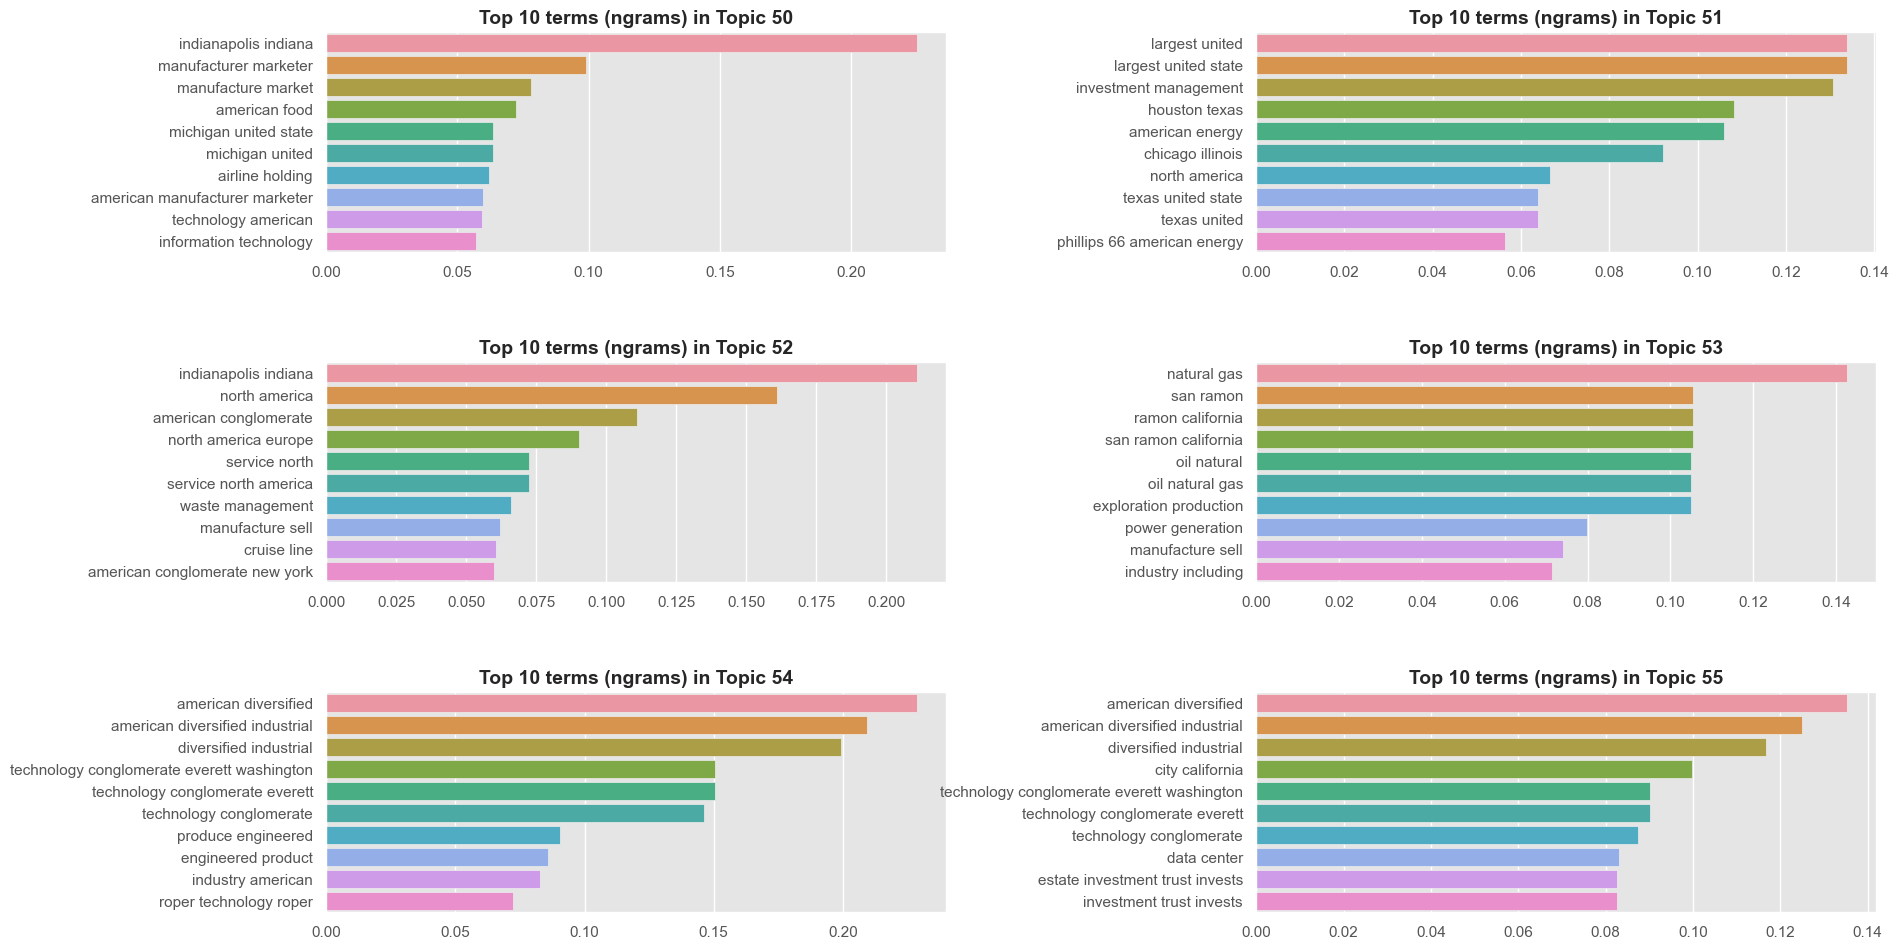

In [151]:
# Plot top 10 terms within each topic
print('-'*50)
print('Plot top terms (ngrams) within each topic\n')
fig1 = plt.figure(figsize=(20, 20))
fig1.subplots_adjust(hspace=.5, wspace=.5)
plt.clf()
for i in range(0, 6):
    fig1.add_subplot(5, 2, i+1)
    temp = word_topic_df.iloc[:, i+50]
    temp = temp.sort_values(ascending=False)
    plt.title(f'Top 10 terms (ngrams) in Topic {i+50}', weight='bold', fontsize=14)
    sns.barplot(x= temp.iloc[:10].values, y=temp.iloc[:10].index)
    i += 1
plt.show()

In [152]:
# dimensionality reduced DF (10000 features to 200 with explained variance of ~50%)
document_topic_df.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  Topic_14  Topic_15  Topic_16  Topic_17  Topic_18  Topic_19  Topic_20  Topic_21  Topic_22  Topic_23  Topic_24  Topic_25  Topic_26  Topic_27  Topic_28  Topic_29  Topic_30  Topic_31  Topic_32  Topic_33  Topic_34  Topic_35  Topic_36  Topic_37  Topic_38  Topic_39  Topic_40  Topic_41  Topic_42  Topic_43  Topic_44  Topic_45  Topic_46  Topic_47  Topic_48  Topic_49  Topic_50  Topic_51  Topic_52  Topic_53  Topic_54  Topic_55  Topic_56  Topic_57  Topic_58  Topic_59  Topic_60  Topic_61  Topic_62  Topic_63  Topic_64  Topic_65  Topic_66  Topic_67  Topic_68  Topic_69  Topic_70  Topic_71  Topic_72  Topic_73  Topic_74  Topic_75  Topic_76  Topic_77  Topic_78  Topic_79  Topic_80  Topic_81  Topic_82  Topic_83  Topic_84  Topic_85  Topic_86  Topic_87  Topic_88  Topic_89  Topic_90  Topic_91  Topic_92  Topic_93  Topic_94  Topic_95  Topic_96  Topic_97  Topic_98   
ticker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
MMM     0.001317  0.010219  0.000106 -0.003857 -0.002021  0.019183  0.040101 -0.011085  0.001204 -0.001948 -0.001927 -0.000436  0.000209 -0.004487  0.000372 -0.004192 -0.027307  0.008744  0.004591 -0.010164 -0.015428  0.009803 -0.009713 -0.002955 -0.004814  0.005700 -0.001859 -0.006166  0.006633  0.020367  0.074525  0.004161 -0.005148 -0.003867  0.043065 -0.023706  0.003831 -0.002228 -0.022095  0.010569  0.004222 -0.007223 -0.011055 -0.013808 -0.027346 -0.005787  0.013986 -0.008183 -0.022163  0.006542 -0.016995 -0.032224  0.047727 -0.001242  0.012539 -0.001666 -0.027138 -0.015265  0.024017  0.000844 -0.041263  0.028122  0.019885 -0.019935 -0.011633  0.065099 -0.062193  0.075052 -0.027361  0.023025 -0.030104 -0.064000 -0.003701 -0.020419 -0.084608 -0.002410  0.006086 -0.019950 -0.039354  0.043173  0.001440 -0.028588  0.019754  0.028339  0.001628  0.006614 -0.026326  0.006440 -0.022227  0.010321  0.018522  0.002821  0.017168  0.011715  0.028188 -0.026262 -0.000589 -0.030621  0.034437  \
AOS     0.000394  0.006185  0.001340 -0.003471  0.000504  0.000118  0.008611 -0.004177  0.002942  0.039703  0.006974  0.004752  0.000056 -0.017692 -0.009791 -0.016675 -0.019330  0.010432  0.001929  0.010313 -0.028788  0.010663  0.018272 -0.097751  0.022460  0.023826  0.025265  0.025914 -0.010179  0.023462 -0.000306 -0.022752 -0.024392 -0.121493 -0.124298 -0.053155  0.043035  0.155302  0.061141 -0.010606 -0.081234  0.002686  0.014105 -0.017744 -0.003380 -0.031484 -0.037308  0.061972 -0.040341 -0.033148 -0.001780  0.069178  0.144809 -0.025846 -0.017143 -0.030381  0.026226 -0.013315 -0.045307  0.027732 -0.017252 -0.026212  0.033407  0.004498 -0.019816  0.036454 -0.026658 -0.001352  0.006780 -0.043780 -0.012182  0.037512  0.040922  0.009096  0.025435  0.005708 -0.042334 -0.011640 -0.001619  0.038233 -0.005388 -0.010580  0.012631  0.043989 -0.002605  0.004949 -0.026396  0.011282 -0.065969  0.014924 -0.069577 -0.043134  0.000093  0.012794  0.005099  0.010228  0.022722  0.010211  0.046816   
ABT     0

---

### 3. Combined Feature space creation

In [153]:
final_features_df = pd.concat([ratios_pp_df, document_topic_df], axis=1, join='inner')
# standard scaling and normalisation
final_features_df = std_normalise_data(final_features_df)
print(final_features_df.shape)
final_features_df.head()

(500, 212)


PC_0      PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7      PC_8      PC_9     PC_10     PC_11   Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  Topic_14  Topic_15  Topic_16  Topic_17  Topic_18  Topic_19  Topic_20  Topic_21  Topic_22  Topic_23  Topic_24  Topic_25  Topic_26  Topic_27  Topic_28  Topic_29  Topic_30  Topic_31  Topic_32  Topic_33  Topic_34  Topic_35  Topic_36  Topic_37  Topic_38  Topic_39  Topic_40  Topic_41  Topic_42  Topic_43  Topic_44  Topic_45  Topic_46  Topic_47  Topic_48  Topic_49  Topic_50  Topic_51  Topic_52  Topic_53  Topic_54  Topic_55  Topic_56  Topic_57  Topic_58  Topic_59  Topic_60  Topic_61  Topic_62  Topic_63  Topic_64  Topic_65  Topic_66  Topic_67  Topic_68  Topic_69  Topic_70  Topic_71  Topic_72  Topic_73  Topic_74  Topic_75  Topic_76  Topic_77  Topic_78  Topic_79  Topic_80  Topic_81  Topic_82  Topic_83  Topic_84  Topic_85  Topic_86   
ticker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
A      -0.032038  0.018990  0.146293  0.035215  0.095953 -0.017174  0.037309  0.049612 -0.078553  0.024288  0.012530 -0.036898 -0.017492 -0.015310 -0.010409 -0.008694  0.010635 -0.003175  0.026378  0.003301  0.014444  0.083282  0.006978 -0.058278  0.086506 -0.007404  0.332696 -0.008897  0.012715 -0.078807  0.167150 -0.113037  0.110701  0.039856 -0.018110 -0.001385 -0.023587 -0.092744  0.037372  0.004143 -0.063720  0.155980  0.008415 -0.075389  0.083166 -0.070653  0.051157  0.031161 -0.073503  0.000423  0.037016  0.053007 -0.053302  0.010826 -0.011364 -0.021478  0.109917  0.095455  0.019530  0.118254  0.056802 -0.046309  0.059957 -0.042224  0.034898 -0.018713  0.109149 -0.081754 -0.084534 -0.049756  0.016337 -0.044774  0.008259  0.005255  0.023429 -0.009211 -0.042137 -0.046643  0.091473 -0.017774  0.020990  0.003658 -0.005077 -0.004990  0.041253  0.040446  0.066798 -0.054633 -0.121874 -0.027429 -0.147158 -0.058574 -0.027045  0.036118 -0.051923  0.066871  0.015387  0.039378  0.033244  \
AAL     0.026775 -0.016796  0.009994  0.083481 -0.082783  0.018842  0.096430 -0.019245  0.022217 -0.002042  0.034145  0.026963  0.006632  0.023583 -0.012335 -0.048534 -0.078907 -0.009973  0.149536  0.344844 -0.049800  0.030106  0.157426  0.186030 -0.088207 -0.184822 -0.039818  0.486103  0.022746  0.013307 -0.107382 -0.110127  0.212953 -0.156044  0.160303  0.127666 -0.060098  0.092132 -0.030553  0.071435 -0.017308 -0.030680  0.002921 -0.007958  0.022354 -0.069500 -0.058117 -0.018015 -0.080644 -0.020496 -0.057355 -0.104407 -0.012382  0.100713 -0.106537  0.010459 -0.036599  0.019733  0.012344  0.057162  0.081949  0.054600  0.076923  0.012736  0.073941  0.112496 -0.016452 -0.023173 -0.042287  0.218779  0.052066 -0.045924  0.068090 -0.052067  0.197109  0.006654 -0.073796  0.075081 -0.115458 -0.062341  0.097921  0.009077  0.072555 -0.003198 -0.003813  0.031962 -0.050688  0.006782 -0.117434  0.074652  0.003303  0.010837  0.045301 -0.003965  0.052868 -0.074281 -0.010519  0.031766  0.004494   
AAP     0.10

In [154]:
# final_features_df.describe(include='all')

<Axes: title={'center': 'Feature space correlation map\n'}>

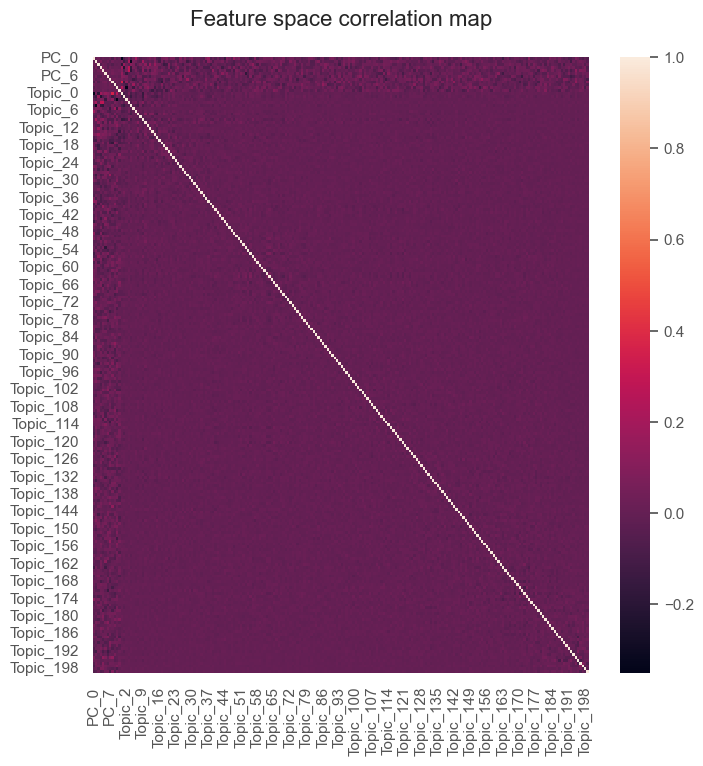

In [155]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Feature space correlation map\n', fontsize=16)
sns.heatmap(final_features_df.corr(), ax=ax)

In [156]:
# sns.pairplot(final_features_df[final_features_df.columns[10:16]], diag_kind='kde')

1. As we can see from the heat map above, all features in the feature space have nearly zero correlation with each other, indicating the goodness of the feature space for model fitting. However the attributes are now all on the same scale, with a mean of 0, standard deviation of 1.

2. The data has no missing values now, nor duplicate entries. Outliers have been identified, but not treated and they are assumed to be real data points & not anomalies in this context for modeling

---

### 4. Model fitting and clustering

Util functions for clustering

In [157]:
def plot_TSNE(data: pd.DataFrame, labels):
    """
    Plot the results of the TSNE algorithm to visualise the 
    cluster densities
    """
    # all stock with its cluster label (including -1)
    clustered_series_all = pd.Series(index=data.index, data=labels)
    # use TSNE algorithm to plot multidimension into 2D
    tsne_data = TSNE(n_components=2, perplexity=80, random_state=1337).fit_transform(data)
    tsne_df = pd.DataFrame(data=tsne_data, index=data.index, columns=['tsne_1', 'tsne_2'])
    tsne_df['label'] = labels
    # clustered
    tsne_df = tsne_df[tsne_df['label'] != -1]
    sns.lmplot(data=tsne_df, x='tsne_1', y='tsne_2', hue='label', height=6, aspect=2, fit_reg=False, legend=True, scatter_kws={'s':150, 'alpha': 0.35})
    # unclustered in the background
    plt.scatter(tsne_data[(clustered_series_all==-1).values, 0], tsne_data[(clustered_series_all==-1).values, 1], s=50, alpha=0.05)
    plt.title('t-SNE plot for all stocks with cluster labels\n', weight='bold').set_fontsize('14')
    plt.xlabel('t-SNE comp 1', weight='bold', fontsize=12)
    plt.ylabel('t-SNE comp 2', weight='bold', fontsize=12)
    plt.show()
    return clustered_series_all


# show number of stocks in each cluster 
def plot_cluster_counts(labels_df: pd.DataFrame):
    """
    Plot cluster counts histogram bar chart
    """
    plt.figure(figsize=(12,8))
    labels_df[labels_df!=-1].value_counts().sort_index().plot(kind='barh')
    plt.title('Cluster stock counts\n', weight='bold', fontsize=12)
    plt.xlabel('Stocks in Cluster', weight='bold', fontsize=10)
    plt.ylabel('Cluster Number', weight='bold', fontsize=10)
    plt.show()

# plot price movements for cluster members
def plot_cluster_members(labels_df: pd.DataFrame):
    """
    Plot the cluster members' log prices
    to observe if they follow a similar path 
    """
    # get the number of stocks in each cluster 
    counts = labels_df[labels_df!=-1].value_counts()
    # let's visualize some clusters
    cluster_vis_list = list(counts[counts>1].sort_values().index)
    # this code needs to be replaced with code to fetch from db
    hist_price_df = pd.read_csv('../data/stocks_hist_price.csv', date_parser=['date'])
    hist_price_df.date = pd.to_datetime(hist_price_df.date, format='ISO8601')
    temp_df = hist_price_df.pivot_table(values='Adj Close', index='date', columns='ticker')
    # plot a handful of the smallest clusters
    plt.figure(figsize=(24, 48))
    fig1.subplots_adjust(hspace=.5, wspace=.25)
    plt.clf()
    i=1
    for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
        tickers = list(labels_df[labels_df==clust].index)
        means = np.log(temp_df.loc[:dt.datetime(2019, 12, 31), tickers].mean())
        data = np.log(temp_df.loc[:dt.datetime(2019, 12, 31), tickers]).sub(means)
        plt.subplot(4, 1, i) 
        plt.plot(temp_df.loc[:dt.datetime(2019, 12, 31), tickers].index, data)
        plt.title(f'Time series of log returns for stocks in Cluster {clust}\n', weight='bold', fontsize=14)
        plt.xlabel('Date', weight='bold', fontsize=12)
        plt.ylabel('Log returns', weight='bold', fontsize=12)
        tkr_names = [f'{tkr} - {sp500_stocks_profile_df[sp500_stocks_profile_df.ticker == tkr].company_name.values[0]}' for tkr in tickers]
        plt.legend(tkr_names)
        i+=1
    plt.show()

##### ****************************************************************************

#### 4.1 Partitional Clustering - K-means

Partitional clustering divides data objects into nonoverlapping groups. In other words, no object can be a member of more than one cluster, and every cluster must have at least one object.

K-Means is the most common unsupervised learning technique, mostly due to its simplicity and effectiveness. It is a fast algorithm, that can run on millions of observations, but it does have its drawbacks. First of all, it does not perform well with data structures that are not spherical. It also does not perform well when the density of points is heterogeneous, meaning that in some areas of the distribution the density is higher than in others. Finally, the number of clusters K has to also be chosen, requiring a somewhat qualitative decision to be made.

While for the first two issues there is not a remedy other than choosing another algorithm, the number of clusters K can be chosen in a relatively rigorous manner. We can iteratively run the K-Means algorithm with an increasing number of K until a somewhat large number (e.g. 50). Then, we can plot a performance measure for each value of K on a chart. By inspecting the chart, we can find the “elbow”, meaning where the performance peaks, for then yielding marginal returns at higher values of K. The value of K we can choose is exactly when the performance gain is marginal with respect to the increase in K. Out of the many performance measures, the most used are usually, Silhouette Coefficient, Distortion and Gap Statistic. We have used the Silhouetter Coefficient for evaluating the performance.

--------------------------------------------------
Find the optimal k value for fitting K-means model

Knee point, SS : (17, 0.018274692045574626)


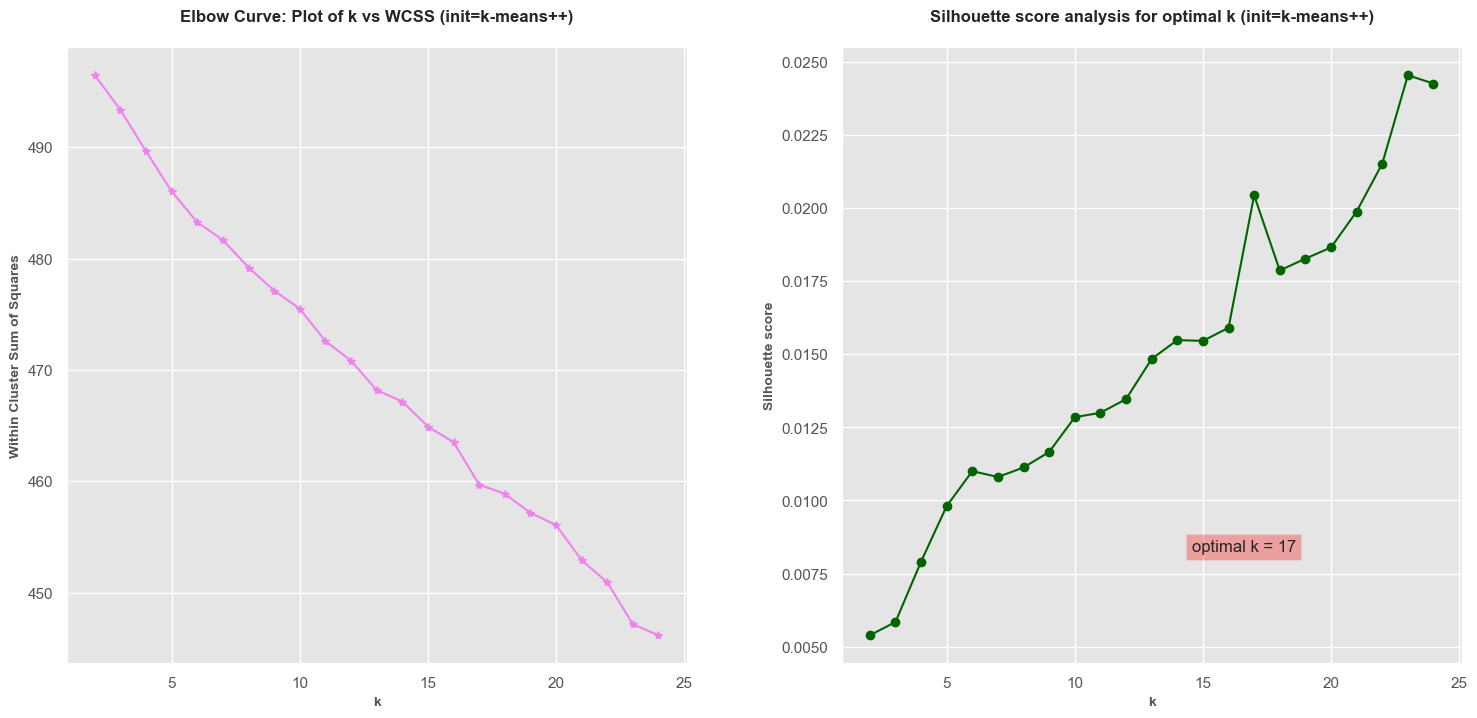

Optimal k based on Elbow curve: None

Optimal k based on Silhouette score analysis: 17


------------------------------------

TSNE plot for the model


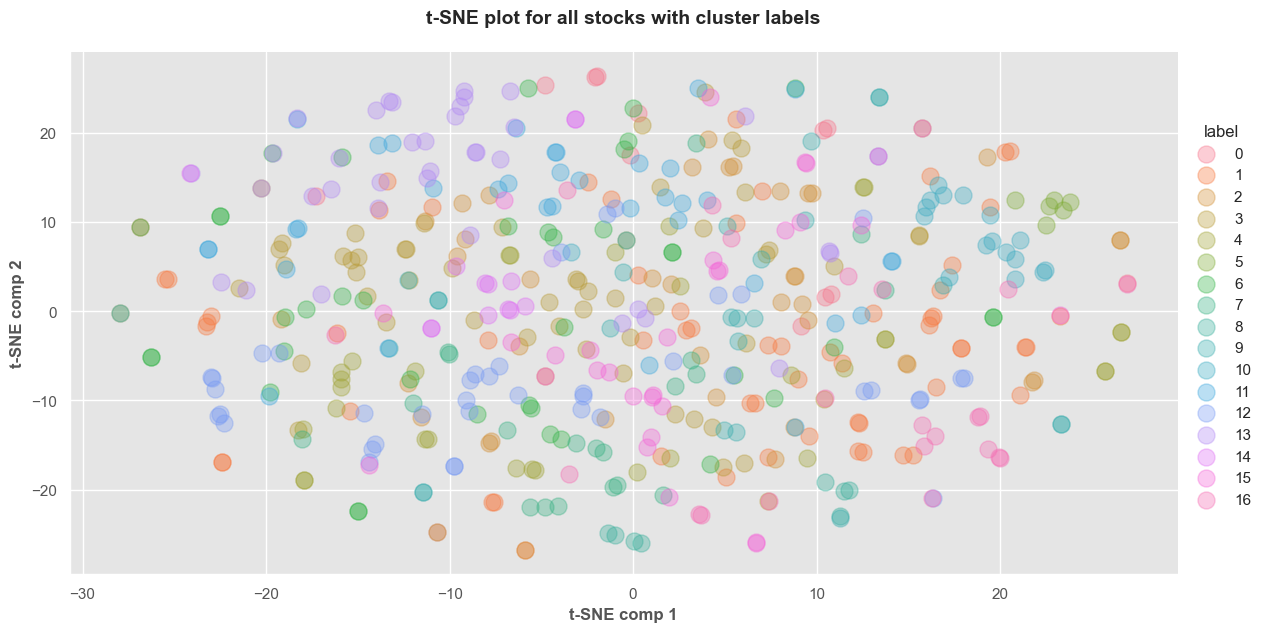


------------------------------------

Cluster counts bar chart


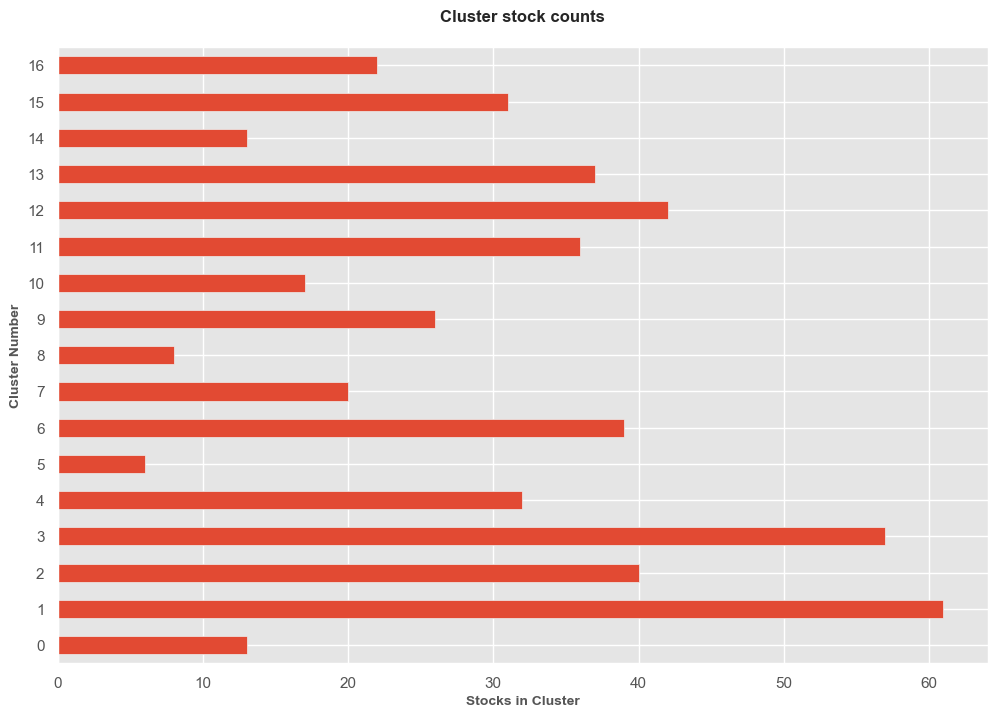


------------------------------------

Cluster member price movements: sample plots of 4 smallest clusters


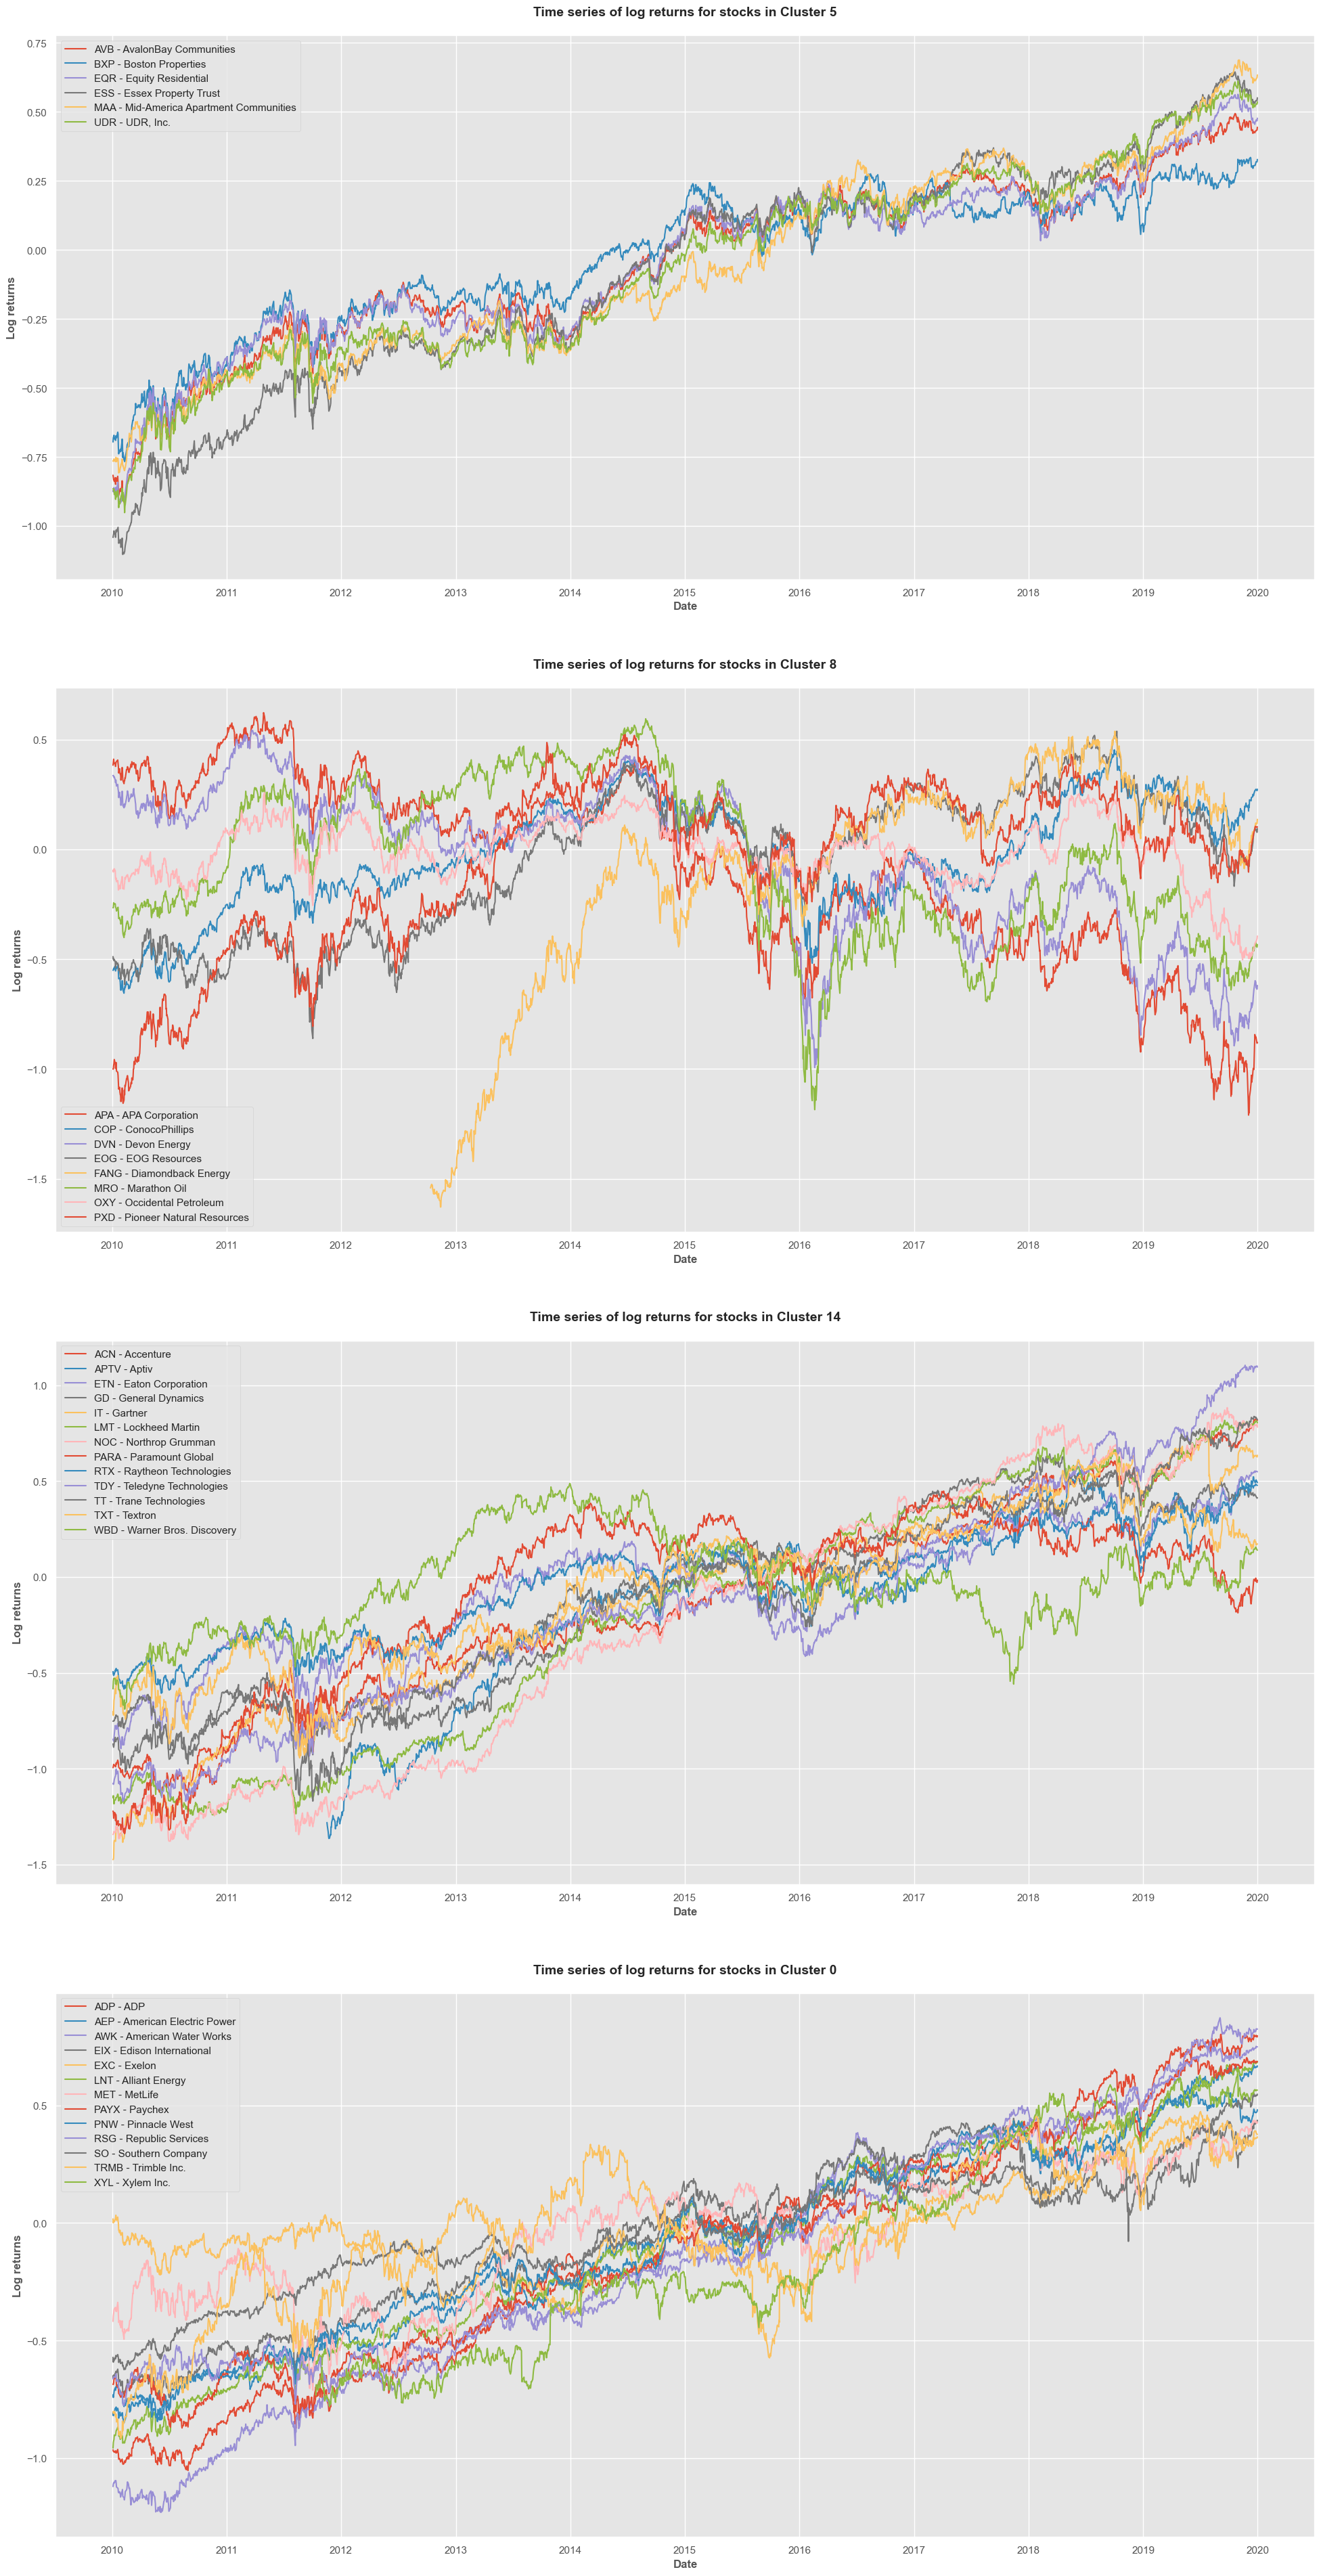

In [158]:
# DF to store the cluster labels for individual stocks
final_cluster_df = None

def find_optimal_k(data = pd.DataFrame(), k_range: range=range(2, 50), init: str='k-means++'):
    """
    Plot the elbow curve & compute silhouette scores to find optimal 'k' for k-means
    for a range of k values.
    """
    WCSS = []
    SS = []
    for k in k_range:
        km = KMeans(n_clusters = k, init=init, max_iter=20000, n_init=100, random_state=1500)
        km.fit(data)
        WCSS += [km.inertia_]
        SS += [silhouette_score(data, labels=km.labels_, random_state=1500)]
    # plot the charts
    fig1 = plt.figure(figsize=(18, 8))
    fig1.subplots_adjust(hspace=.5, wspace=.25)
    plt.clf()
    # Elbow curve for WCSS scores
    plt.subplot(1, 2, 1)
    plt.plot(k_range, WCSS, color='violet', marker='*')
    plt.xlabel('k', weight='bold', fontsize=10)
    plt.ylabel('Within Cluster Sum of Squares', weight='bold', fontsize=10)
    plt.title(f'Elbow Curve: Plot of k vs WCSS (init={init})\n', weight='bold', fontsize=12)
    knee_elbow = KneeLocator(k_range, WCSS, S=10, online=True,  curve='convex', direction='decreasing', interp_method='interp1d')
    if knee_elbow.knee!=None and knee_elbow.knee in range(len(WCSS)):
        plt.axvline(x=knee_elbow.knee, ymax=0.95, ymin=0.05, color='brown', ls='--')
        print(f'Knee point, WCSS : {knee_elbow.knee, WCSS[knee_elbow.knee]}')
        plt.figtext(0.25, 0.25, f'optimal k = {knee_elbow.knee}', bbox=dict(facecolor='red', alpha=0.3), fontsize=12)

    # Silhouette scores plot
    plt.subplot(1, 2, 2)
    plt.plot(k_range, SS, color='darkgreen', marker='o')
    plt.xlabel('k', weight='bold', fontsize=10)
    plt.ylabel('Silhouette score', weight='bold', fontsize=10)
    plt.title(f'Silhouette score analysis for optimal k (init={init})\n', weight='bold', fontsize=12)
    knee_ss = KneeLocator(k_range, SS, S=10, online=True, curve='concave', direction='increasing', interp_method='interp1d')
    if knee_ss.knee!=None and knee_ss.knee in range(len(SS)):
        print(f'Knee point, SS : {knee_ss.knee, SS[knee_ss.knee]}')
        plt.figtext(0.75, 0.25, f'optimal k = {knee_ss.knee}', bbox=dict(facecolor='red', alpha=0.3), fontsize=12)
    plt.show()
    return knee_elbow.knee, knee_ss.knee

def km_final_fit(data_df: pd.DataFrame, opt_k: int):
    """
    Plot all charts for the K-means model predictions 
    """
    # Fit the K-means model on the data with the optimal 'k'
    k_final = opt_k # we get this value from either Elbow test or Silhouette score analysis
    km_final = KMeans(n_clusters = k_final, init='k-means++', max_iter=20000, n_init=100, random_state=1500)
    km_final = km_final.fit(data_df)
    km_final_clusters_df = pd.DataFrame(index=data_df.index, columns=['km_cluster'])
    km_final_clusters_df['km_cluster'] = km_final.labels_

    # TSNE
    print('\n------------------------------------\n')
    print('TSNE plot for the model')
    labels_df = plot_TSNE(data_df, km_final.labels_)
    # plot cluster count (bar chart)
    print('\n------------------------------------\n')
    print('Cluster counts bar chart')
    plot_cluster_counts(labels_df)
    # plot cluster members
    print('\n------------------------------------\n')
    print('Cluster member price movements: sample plots of 4 smallest clusters')
    plot_cluster_members(labels_df)

    return km_final_clusters_df

print('-'*50)
print('Find the optimal k value for fitting K-means model\n')
opt_k_elbow, opt_k_SS = find_optimal_k(final_features_df, k_range=range(2, 25), init='k-means++')
print(f'Optimal k based on Elbow curve: {opt_k_elbow}\n')
print(f'Optimal k based on Silhouette score analysis: {opt_k_SS}\n')
km_cluster_df = None
if opt_k_SS!=None or opt_k_elbow!=None:
    k_final = 0
    if opt_k_elbow == None:
        k_final = opt_k_SS
    elif opt_k_SS == None:
        k_final = opt_k_elbow
    else:
        k_final = min(opt_k_elbow, opt_k_SS)
    # fit K-means using the derived optimal k value 
    km_cluster_df = km_final_fit(final_features_df, opt_k=k_final)
else:
    raise Exception("No optimal value for k found!")


In [159]:
if (not km_cluster_df.empty):
    print(km_cluster_df.head())

        km_cluster
ticker            
A               12
AAL              1
AAP             16
AAPL             4
ABBV             3


##### ******************************************************************

#### 4.2 Density based clustering - OPTICS

Density-based clustering determines cluster assignments based on the density of data points in a region. Clusters are assigned where there are high densities of data points separated by low-density regions.

Unlike the other clustering categories, this approach doesn’t require the user to specify the number of clusters. Instead, there is a distance-based parameter that acts as a tunable threshold. This threshold determines how close points must be to be considered a cluster member.

OPTICS stands for Ordering points to identify the clustering structure. It is a density-based unsupervised learning algorithm, which was developed by the same research group that developed DBSCAN.

A single cutoff of distance is applied in DBSCAN to determine whether two data points are close to each other (neighbors) or not. But it may not always be an ideal solution because a “long” distance in one cluster could be a “short” distance in another. In OPTICS each point is assigned a core distance that describes the distance to the MinPtsth closest point, and a reachability distance of another point o from a point p that is either the distance between o and p, or the core distance of p, whichever is bigger.

Running density based clustering - OPTICS model
----------------------------------------------------------------------------------------------------
max_eps: inf
min_samples: 5
model fit params: {'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 30, 'max_eps': inf, 'memory': None, 'metric': 'minkowski', 'metric_params': None, 'min_cluster_size': None, 'min_samples': 5, 'n_jobs': None, 'p': 2, 'predecessor_correction': True, 'xi': 0.01}


The Silhouette Score for our OPTICS model fit on preprocessed & scaled data : 0.010641710904785998

The Calinski Harabasz Score for our OPTICS model fit on preprocessed & scaled data : 2.5646171926742483
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TSNE plot for the model


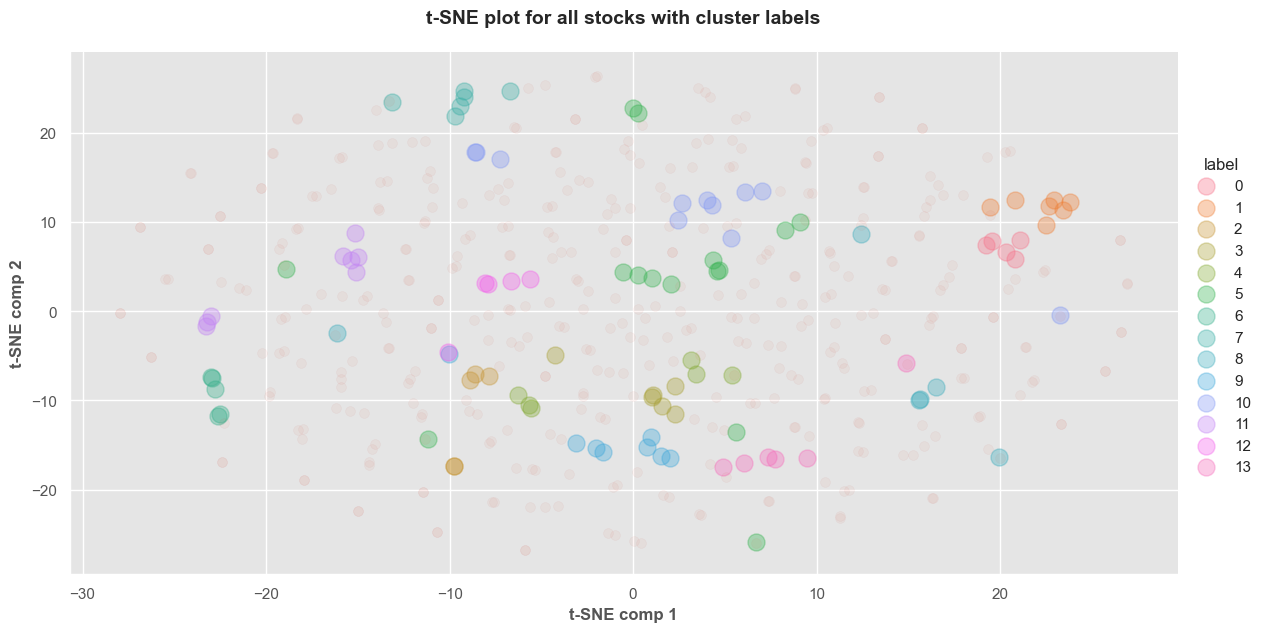

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster counts bar chart


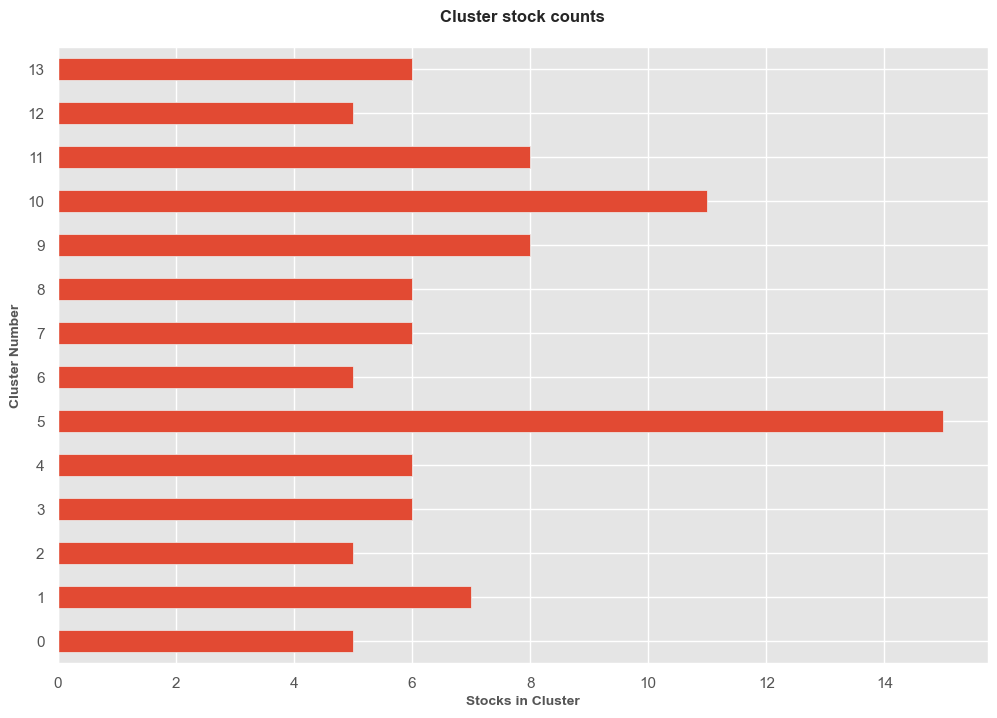

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster member price movements: sample plots of 4 least dense clusters


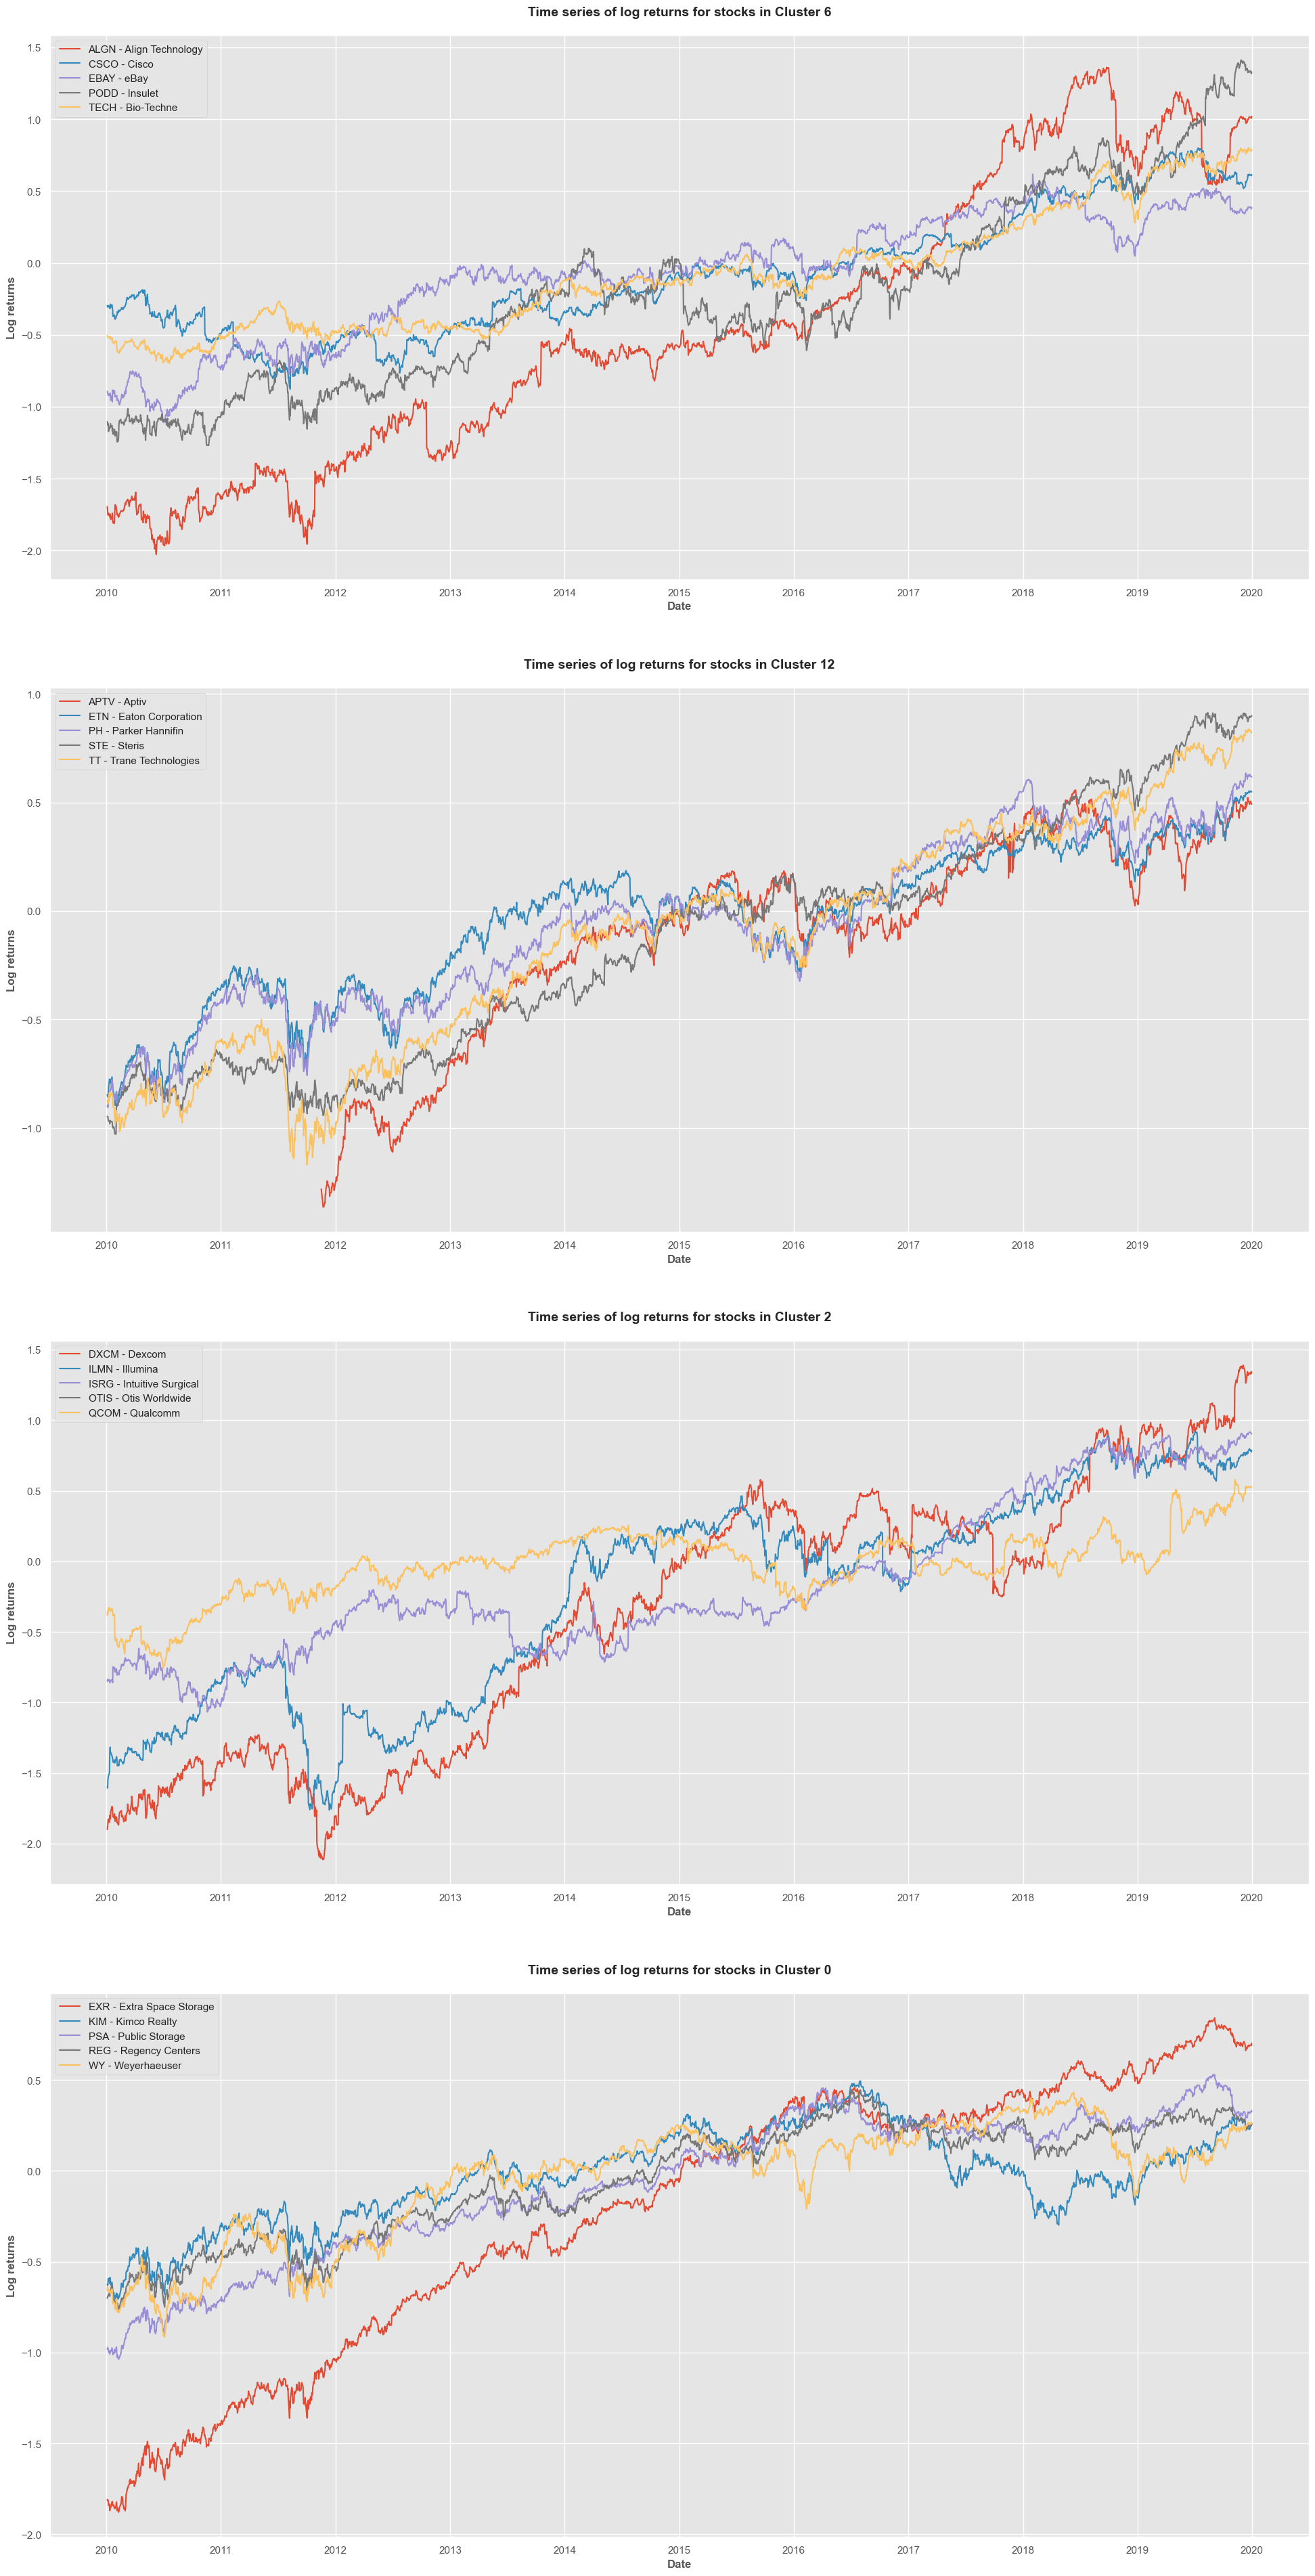

In [160]:
def optics_fit(data_df: pd.DataFrame, max_eps: float=np.inf, min_samples: int=5):
    """
    Fit OPTICS clustering algorithm over the data;
    Plot all charts for the model predictions 
    """
    print('Running density based clustering - OPTICS model')
    print('--'*50)
    print(f'max_eps: {max_eps}\nmin_samples: {min_samples}')
    db = OPTICS(max_eps=max_eps, min_samples=min_samples, xi=0.01).fit(data_df)
    labels = db.labels_
    print(f'model fit params: {db.get_params()}\n')
    # Compute Silouette score
    sil_score = silhouette_score(data_df, labels=labels, random_state=1500)
    print(f'\nThe Silhouette Score for our OPTICS model fit on preprocessed & scaled data : {sil_score}')
    # Compute Calinski Harabasz score
    cal_hb_score = calinski_harabasz_score(data_df, labels=labels)
    print(f'\nThe Calinski Harabasz Score for our OPTICS model fit on preprocessed & scaled data : {cal_hb_score}')
    
    # TSNE
    print('--'*100)
    print('TSNE plot for the model')
    labels_df = plot_TSNE(data_df, labels)
    # plot cluster count (bar chart)
    print('--'*100)
    print('Cluster counts bar chart')
    plot_cluster_counts(labels_df)
    # plot cluster members
    print('--'*100)
    print('Cluster member price movements: sample plots of 4 least dense clusters')
    plot_cluster_members(labels_df)

    db_final_clusters_df = pd.DataFrame(index=data_df.index, columns=['db_cluster'])
    db_final_clusters_df['db_cluster'] = labels
    return db_final_clusters_df

db_cluster_df = optics_fit(final_features_df, min_samples=5)

In [161]:
if (not db_cluster_df.empty):
    print(db_cluster_df.head())

        db_cluster
ticker            
A               -1
AAL             11
AAP             -1
AAPL            -1
ABBV            11


##### *****************************************************************

#### 4.3 Hierarchical clustering - Agglomerative

Hierarchical clustering determines cluster assignments by building a hierarchy. This is implemented by either a bottom-up or a top-down approach:

1. Agglomerative clustering is the bottom-up approach. It merges the two points that are the most similar until all points have been merged into a single cluster.

2. Divisive clustering is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain.

These methods produce a tree-based hierarchy of points called a dendrogram. Similar to partitional clustering, in hierarchical clustering the number of clusters (k) is often predetermined by the user. Clusters are assigned by cutting the dendrogram at a specified depth that results in k groups of smaller dendrograms.

Unlike many partitional clustering techniques, hierarchical clustering is a deterministic process, meaning cluster assignments won’t change when you run an algorithm twice on the same input data.

We'll consider Agglomerative clustering for our dataset

Running hierarchical clustering (bottom-up approach) - Agglomerative model
----------------------------------------------------------------------------------------------------
n_clusters: 14
model fit params: {'affinity': 'deprecated', 'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'metric': 'euclidean', 'n_clusters': 14}


The Silhouette Score for our Agglomerative model fit on preprocessed & scaled data : 0.01884243002394725

The Calinski Harabasz Score for our Agglomerative model fit on preprocessed & scaled data : 2.611126314563002
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TSNE plot for the model


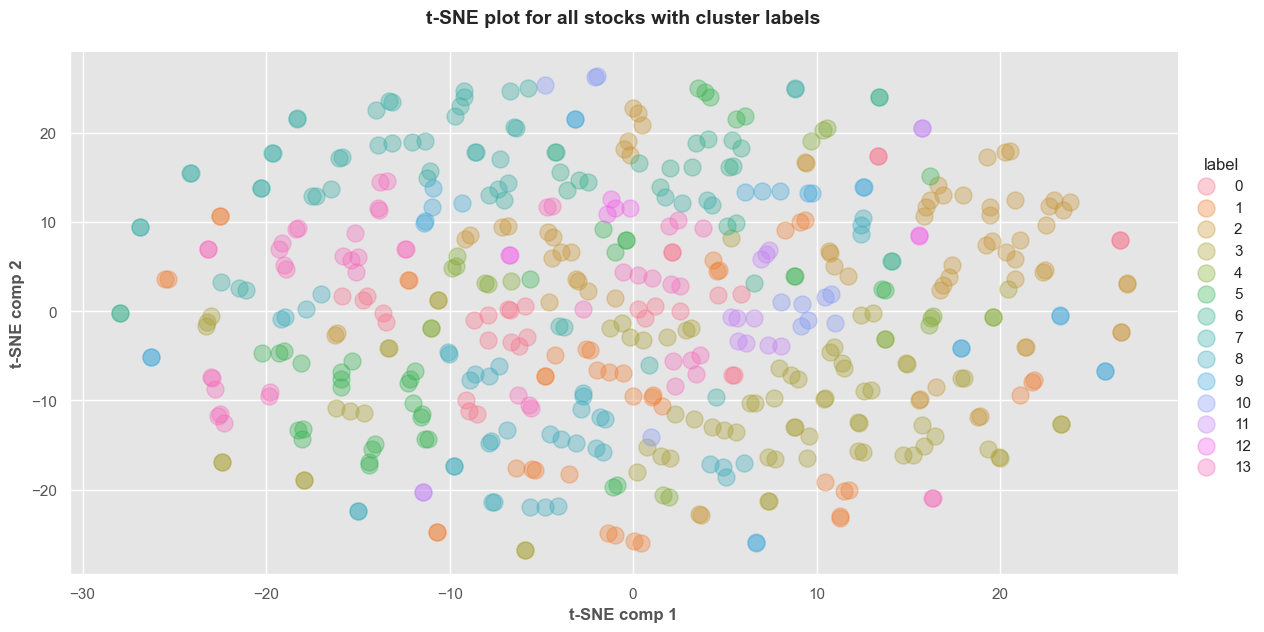

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster counts bar chart


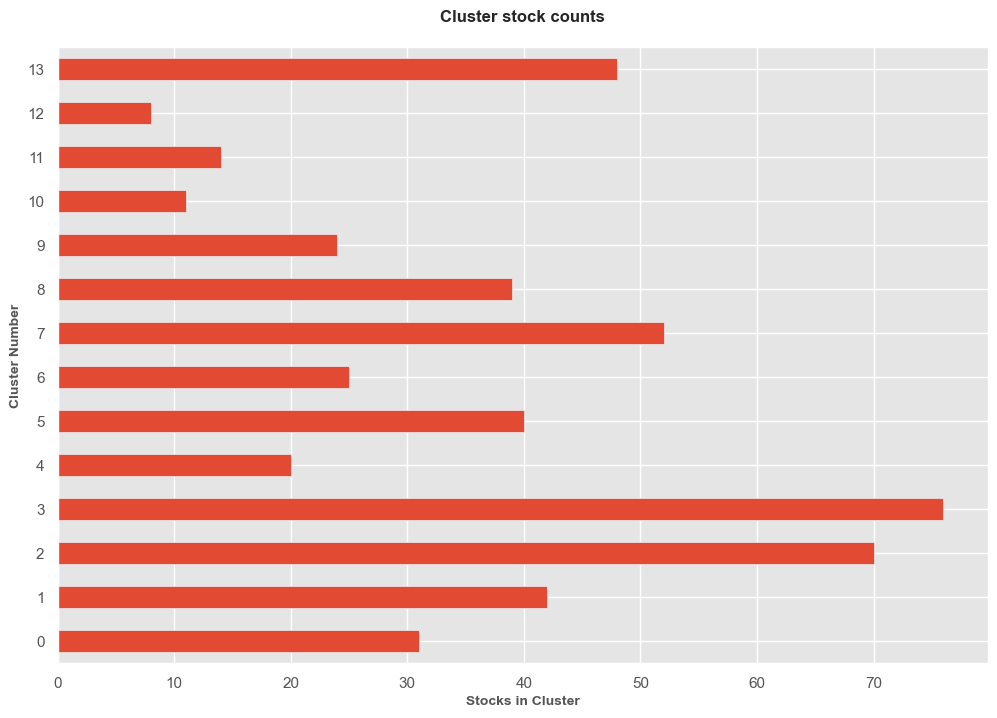

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster member price movements: sample plots of 4 least dense clusters


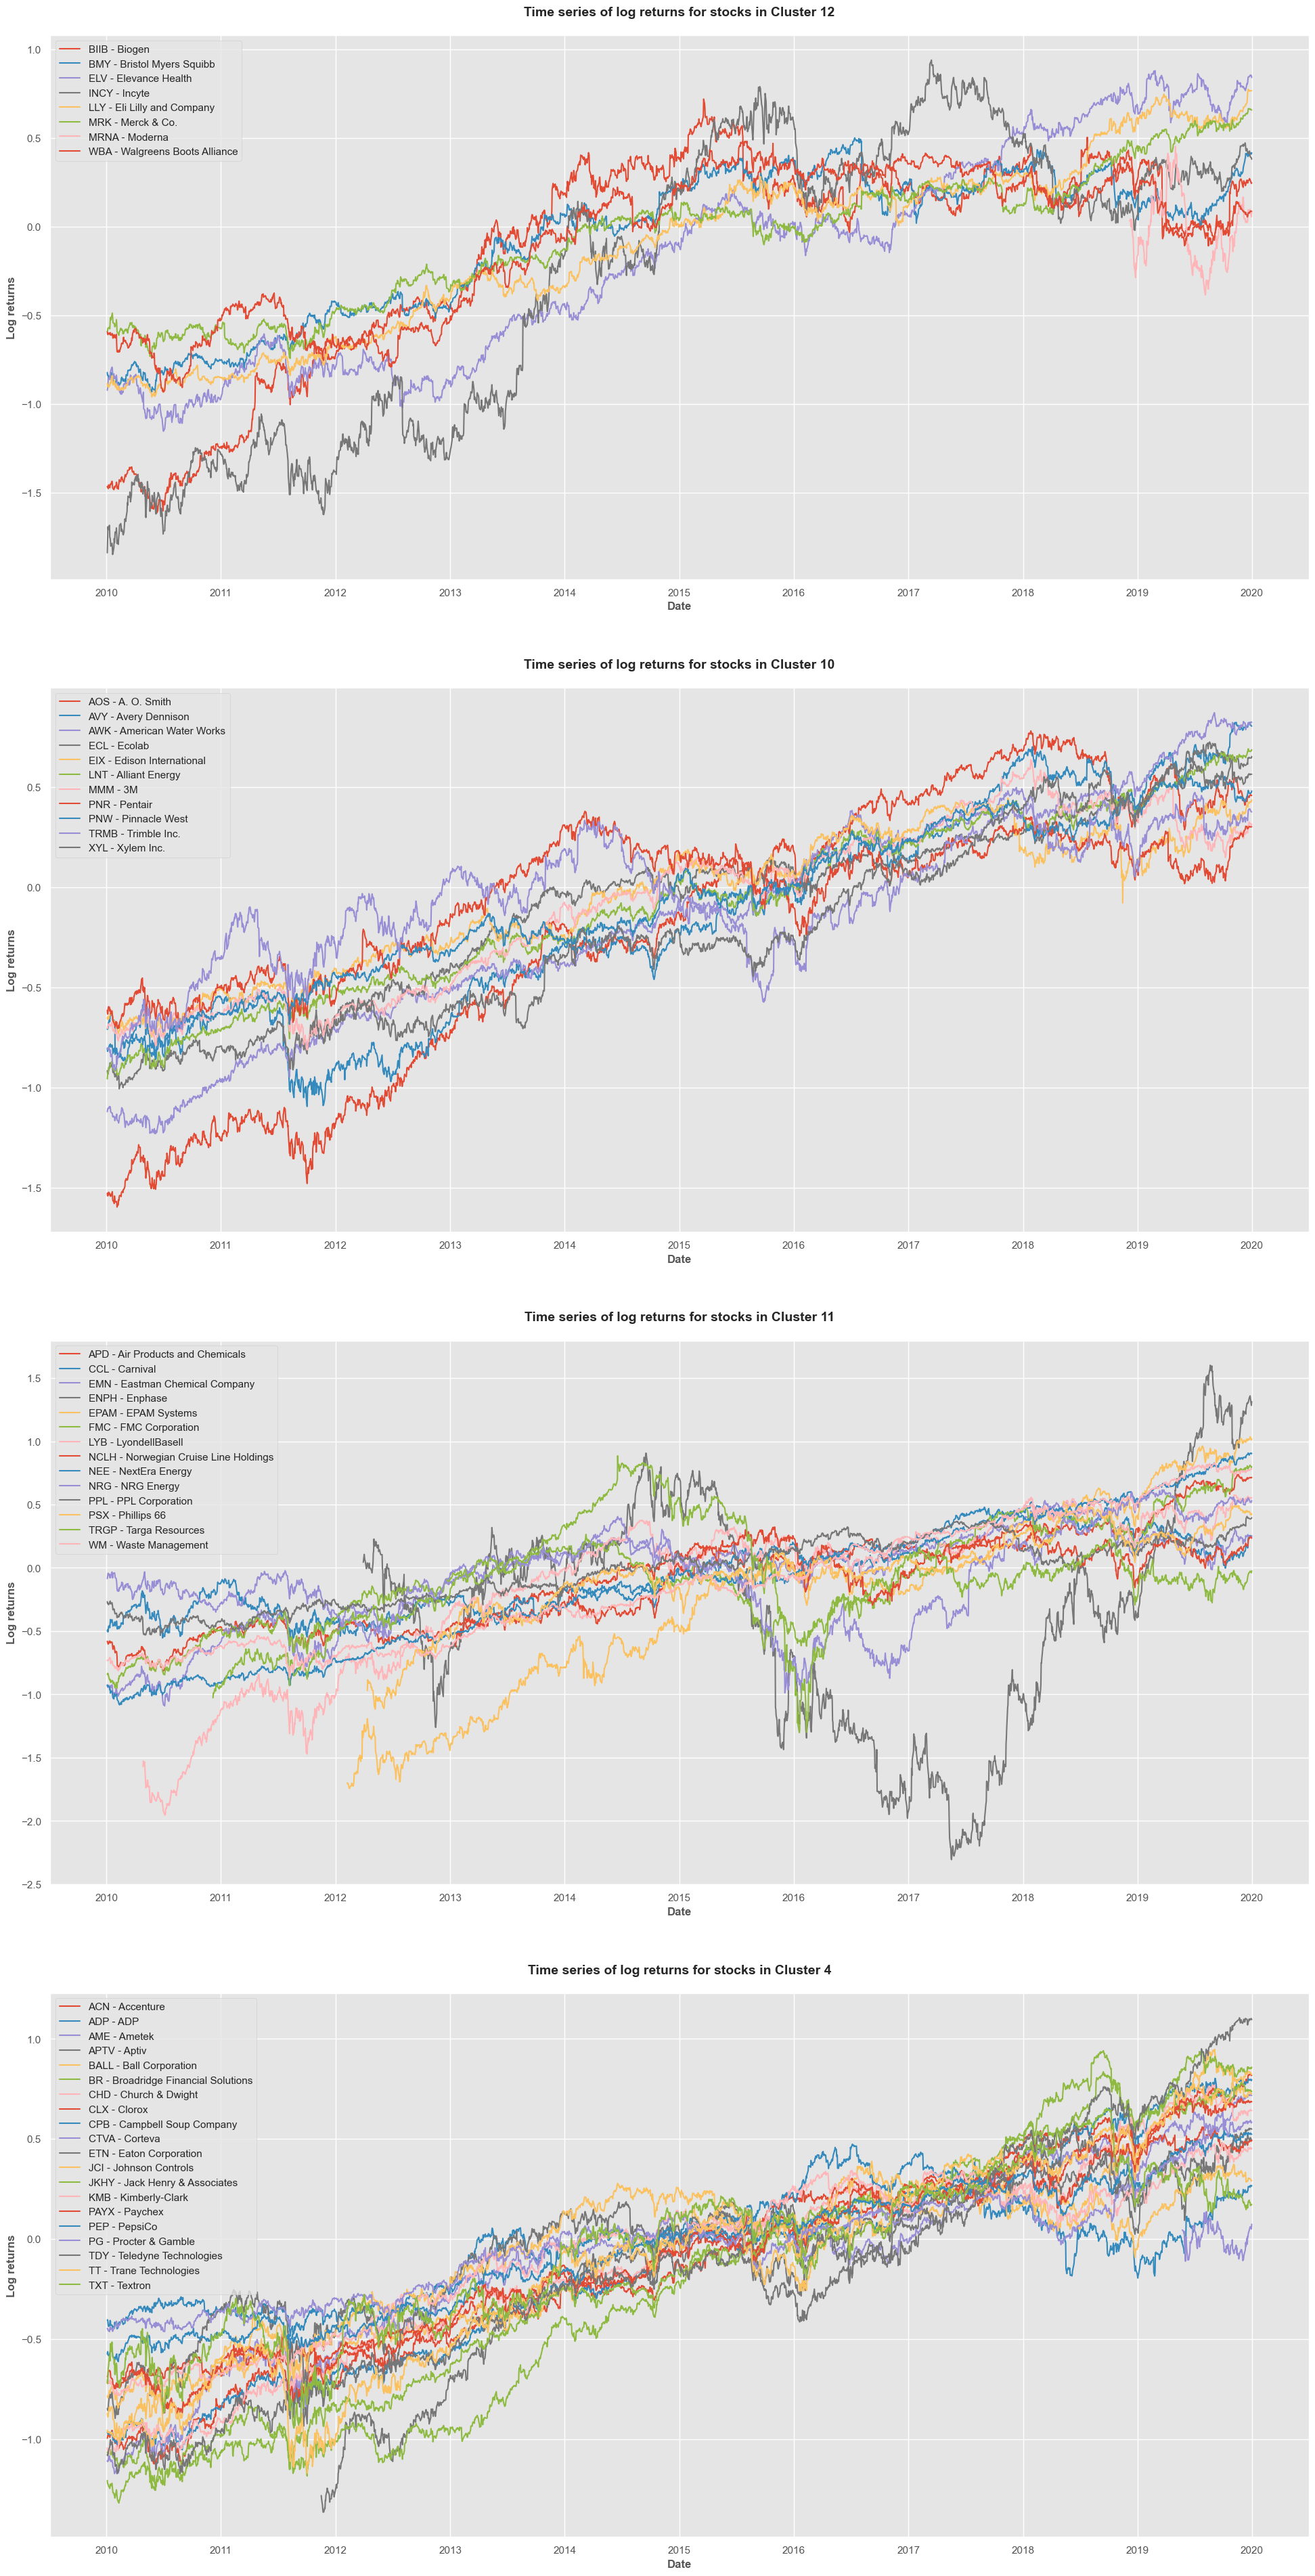

In [162]:
def agg_hc_fit(data_df: pd.DataFrame, n_clusters: int=10, linkage: str='average'):
    """
    Fit Agglomerative Clustering algorithm over the data;
    Plot all charts for the model predictions 
    """
    print('Running hierarchical clustering (bottom-up approach) - Agglomerative model')
    print('--'*50)
    print(f'n_clusters: {n_clusters}')
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage=linkage).fit(data_df)
    labels = hc.labels_
    print(f'model fit params: {hc.get_params()}\n')
    # Compute Silouette score
    sil_score = silhouette_score(data_df, labels=labels, random_state=1500)
    print(f'\nThe Silhouette Score for our Agglomerative model fit on preprocessed & scaled data : {sil_score}')
    # Compute Calinski Harabasz score
    cal_hb_score = calinski_harabasz_score(data_df, labels=labels)
    print(f'\nThe Calinski Harabasz Score for our Agglomerative model fit on preprocessed & scaled data : {cal_hb_score}')
    
    # TSNE
    print('--'*100)
    print('TSNE plot for the model')
    labels_df = plot_TSNE(data_df, labels)
    # plot cluster count (bar chart)
    print('--'*100)
    print('Cluster counts bar chart')
    plot_cluster_counts(labels_df)
    # plot cluster members
    print('--'*100)
    print('Cluster member price movements: sample plots of 4 least dense clusters')
    plot_cluster_members(labels_df)

    hc_final_clusters_df = pd.DataFrame(index=data_df.index, columns=['hc_cluster'])
    hc_final_clusters_df['hc_cluster'] = labels
    return hc_final_clusters_df

hc_cluster_df = agg_hc_fit(final_features_df, n_clusters=14, linkage='average')

In [163]:
if (not hc_cluster_df.empty):
    print(hc_cluster_df.head())

        hc_cluster
ticker            
A                0
AAL              3
AAP              3
AAPL             5
ABBV            13


##### ***************************************************************

In [164]:
# finally, merge DFs for all clustering results to get a singular cluster labels DF
final_cluster_df = pd.concat([km_cluster_df, db_cluster_df, hc_cluster_df], axis=1)
final_cluster_df['sector'] = [sp500_stocks_profile_df[sp500_stocks_profile_df['ticker'] == tkr]['sector'].values[0] for tkr in final_cluster_df.index]
final_cluster_df = final_cluster_df[['sector', 'km_cluster', 'db_cluster', 'hc_cluster']]
final_cluster_df.head(15)

sector  km_cluster  db_cluster  hc_cluster
ticker                                                            
A                  Health Care          12          -1           0
AAL                Industrials           1          11           3
AAP     Consumer Discretionary          16          -1           3
AAPL    Information Technology           4          -1           5
ABBV               Health Care           3          11          13
ABC                Health Care           3          -1           6
ABT                Health Care           1          -1           8
ACGL                Financials          13          -1           7
ACN     Information Technology          14          -1           4
ADBE    Information Technology           4          -1           5
ADI     Information Technology           6           4          13
ADM           Consumer Staples           7          -1           6
ADP                Industrials           0          -1           4
ADSK    Information Technology          12          -1           5
AEE                  Utilities           9          -1           6